In [2]:
import torch
from torch import nn

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable
import time

#import import_ipynb

import torch.nn.functional as F

In [5]:
nvidia-smi

NameError: ignored

In [ ]:

from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/CNN'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/CNN


In [ ]:
# Default constants
LEARNING_RATE = 1e-2
MAX_EPOCHS = 10
BATCH_SIZE = 32

# use for crossentropy classification because the output is a vector of probabilities that hardly can be compared with the target vector of labels when one-hot encoded makes these integers from 0 to 14 (15 classes)
LABEL_SMOOTHING = 0.015

%reload_ext autoreload
%autoreload 2

In [ ]:
num_groups = 4


class MlpModel(nn.Module):
    def __init__(self, inputSize, numClasses):
        super(MlpModel, self).__init__()

        self.fltn = nn.Flatten()
        self.fc1 = nn.Linear(inputSize, 128)
        # self.bc1 = nn.BatchNorm1d(128)
        self.bc1 = nn.GroupNorm(num_groups, 128)
        self.relu1 = nn.ReLU(inplace=True)

        self.fc2 = nn.Linear(128, 128)
        self.bc2 = nn.GroupNorm(num_groups, 128)
        self.relu2 = nn.ReLU(inplace=True)

        self.fc21 = nn.Linear(128, 128)
        self.bc21 = nn.GroupNorm(num_groups, 128)
        self.relu21 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(128, 64)
        self.bc3 = nn.GroupNorm(num_groups, 64)
        self.relu3 = nn.ReLU(inplace=True)

        self.fc4 = nn.Linear(64, 64)
        self.bc4 = nn.GroupNorm(num_groups, 64)
        self.relu4 = nn.ReLU(inplace=True)

        self.fc5 = nn.Linear(64, numClasses)

        self.initialize_weights()

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.1)
        self.logsm = nn.LogSoftmax(dim=1)

    def forward(self, x):

        # out = self.fc1(self.fltn(x))
        out = self.fc1(x)
        assert not torch.isnan(out).any()
        out = self.bc1(out)
        out = self.relu1(out)
        out = self.dropout(out)

        out2 = self.fc2(out)
        assert not torch.isnan(out2).any()
        out = self.bc2(out2)
        out = self.relu2(out)
        out = self.dropout(out)

        out21 = self.fc21(out)
        assert not torch.isnan(out21).any()
        out = self.bc21(out21)
        out = self.relu21(out)
        out = self.dropout(out)

        out3 = self.fc3(out)
        assert not torch.isnan(out3).any()
        out3 = self.bc3(out3)
        out = self.relu3(out3)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.bc4(out)
        out = self.relu4(out)
        out4 = self.dropout(out)
        assert not torch.isnan(out4).any()

        out5 = self.fc5(out4)
        assert not torch.isnan(out5).any()
        # print('-----------------------------')
        # out = self.logsm(out)

        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
trainset = dset.CIFAR10(
    "./data_CIFAR10",
    train=True,
    transform=transform,
    target_transform=None,
    download=False,
)
testset = dset.CIFAR10(
    "./data_CIFAR10",
    train=False,
    transform=transform,
    target_transform=None,
    download=False,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape

torch.Size([32, 3, 32, 32])

In [ ]:
# show some random training images
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

image_size = images.shape[-3] * images.shape[-2] * images.shape[-1]
n_classes = len(classes)

In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print("     ".join("%5s" % classes[labels[j]] for j in range(4)))
print()
dataiter = iter(trainloader)
print("trainloader lengh: " + str(len(trainloader)))
print("dataiter lengh: " + str(len(dataiter)))

In [ ]:
import tqdm


def train(mlp_model, optimizer):

    losses = []
    accuracy = []

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    mlp_model.to(DEVICE)
    mlp_model.train()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

    for epoch in range(MAX_EPOCHS):
        timestart = time.time()
        correct = 0

        for step, (batch_x, batch_y) in enumerate(tqdm.tqdm(trainloader), 0):
            # zero the parameter gradients
            optimizer.zero_grad()

            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

            batch_x = batch_x.view(-1, image_size)
            outputs = mlp_model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == batch_y).sum().item()

            accuracy.append(100.0 * correct / batch_y.size(0))

        print("epoch %d cost %3f sec" % (epoch, time.time() - timestart))
    print("Finished Training")
    return losses, accuracy

In [ ]:
mlp_model = MlpModel(image_size, n_classes)
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=LEARNING_RATE)

timestart = time.time()
losses, accuracy = train(mlp_model, optimizer)
total_time = time.time() - timestart

100%|██████████| 1563/1563 [00:22<00:00, 69.97it/s]


epoch 0 cost 22.341546 sec


100%|██████████| 1563/1563 [00:29<00:00, 52.49it/s]


epoch 1 cost 29.785574 sec


100%|██████████| 1563/1563 [00:29<00:00, 53.11it/s]


epoch 2 cost 29.438831 sec


100%|██████████| 1563/1563 [00:30<00:00, 50.64it/s]


epoch 3 cost 30.869211 sec


100%|██████████| 1563/1563 [00:28<00:00, 54.95it/s]


epoch 4 cost 28.448115 sec


100%|██████████| 1563/1563 [00:32<00:00, 47.58it/s]


epoch 5 cost 32.854893 sec


100%|██████████| 1563/1563 [00:38<00:00, 40.12it/s]


epoch 6 cost 38.971277 sec


100%|██████████| 1563/1563 [00:36<00:00, 43.26it/s]


epoch 7 cost 36.139546 sec


100%|██████████| 1563/1563 [00:28<00:00, 54.78it/s]


epoch 8 cost 28.537133 sec


100%|██████████| 1563/1563 [00:27<00:00, 56.89it/s]

epoch 9 cost 27.479906 sec
Finished Training


In [ ]:
from statistics_utils_store import StatisticsSaver

statisticsSaver = StatisticsSaver()
statisticsSaver.save_accuracy(accuracy)
statisticsSaver.save_losses(losses)
statisticsSaver.save_total_training_time(total_time)


statisticsSaver.set_trainned_model(mlp_model)
statisticsSaver.set_trainned_optimizer(optimizer)
output_dir = "out_mlp"


file_path = output_dir + "/" + "file_mlp_model"
statisticsSaver.save_trainned_model(file_path, MAX_EPOCHS)
statisticsSaver.save_model_params(file_path, MAX_EPOCHS)

### Plot trainning results

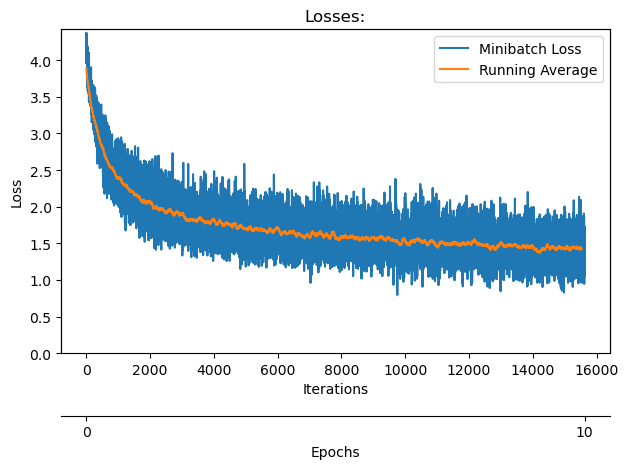

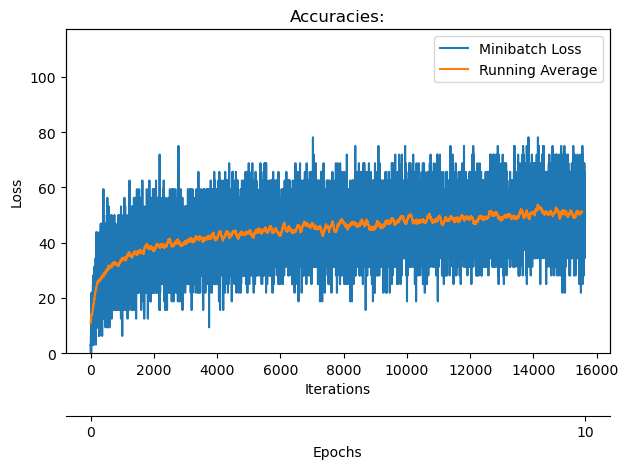

In [ ]:
from plot_helper import plot_training_loss

plot_training_loss(losses, MAX_EPOCHS, "Losses:")
plot_training_loss(accuracy, MAX_EPOCHS, "Accuracies:")

In [ ]:
def test(mlp):
    total = 0
    correct = 0
    accuracy = []

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    mlp.to(DEVICE)
    mlp.eval()
    for step, (batch_x, batch_y) in enumerate(testloader):
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

        batch_x = batch_x.view(-1, 3072)
        outputs = mlp(batch_x)
        assert not torch.isnan(outputs).any()
        # print statistics
        # print("step ",step)
        if step % 20 == 19:  # print every 500 mini-batches
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            accuracy.append(100.0 * correct / total)
            total = 0
            correct = 0
    print("Finished Testing")
    return accuracy

In [ ]:
test_accuracy = test(mlp_model)

Finished Testing


Average test accuracy is : 46.875


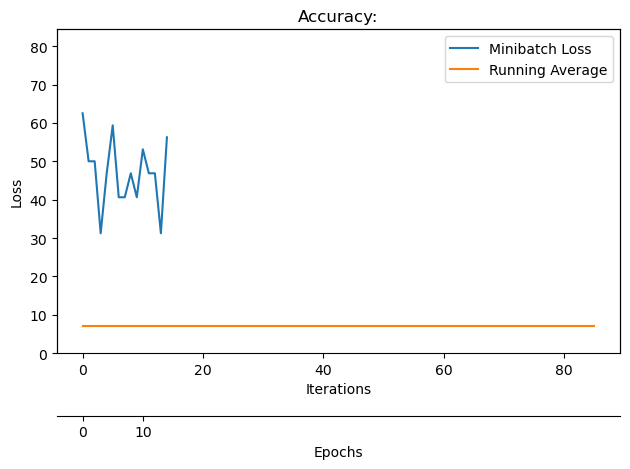

In [ ]:
avg_test_accuracy = np.mean(test_accuracy)
print("Average test accuracy is : " + str(avg_test_accuracy))

plot_training_loss(test_accuracy, MAX_EPOCHS, "Accuracy:")